### 이 코드는 김웅곤님의 코드를 데이터를 바꿔 사용하기 위해서 조금씩 수정하여 만든 코드입니다.
### GitHub <a>https://github.com/kimwoonggon/publicservant_AI</a>

<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_%EB%B2%84%ED%8A%B8_%EB%B9%A0%EB%A5%B4%EA%B2%8C_%EB%8F%8C%EB%A0%A4%EB%B3%B4%EA%B8%B0_With_%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_TUTORIAL(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 #### 구글 드라이브와 Colab을 연동합니다



In [1]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mnt


In [0]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [4]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=349d9466fee2c32958c7a856c0b0ac0fe34ceea0fccaa3642a61f70284537ca3
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=d98abc841f2907836587f9a7db0d1eaf697d71e52e6b1077aac9a62474441b3d
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=eae2dad1c97944400f78a8852f1fc07a2349e6925ef8ddcadaef9119a0e0b651
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=ccc229d7e7c5d90f8e9babc6dc71d43daae8b81aa8cbf3b9f11a34a47db94579
  Stor

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

폴더를 복사하는 함수를 정의합니다. Bert 모델은 현재 GDrive 상에 있습니다.  
 **Colab 클라우드 컴퓨터 안에 Bert 모형을 직접 저장하면, GDRIVE를 경유하는 것보다 사전학습된 모델을 로드하는 시간이 빨라집니다.**

In [0]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

Colab 클라우드 서버에 bert라는 폴더를 생성합니다.

In [7]:
cd /content/mnt/My Drive/Colab Notebooks

/content/mnt/My Drive/Colab Notebooks


In [0]:
data = pd.read_csv("./devmatcing/glowpick_final.csv")

In [9]:
data

,Unnamed: 0,product,brand,user,star,review
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ..."
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...
...,...,...,...,...,...,...
16491,16491,프리미엄TS샴푸,TS,후회없는청춘,별세개,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...
16492,16492,프리미엄TS샴푸,TS,허모찌,별네개,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다. 머리카락이 가늘고 잘 빠지는 편이라...
16493,16493,프리미엄TS샴푸,TS,베싸메,별두개,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...
16494,16494,프리미엄TS샴푸,TS,빠샤이,별두개,아 어쩐지 아무 효과 없더라.. TS 종류 많은거 몰랐네요.. 다 떨어져서 엄마랑 ...


In [10]:
stars = list(data['star'])

label = []

for i in range(len(stars)):
  if stars[i] == '별다섯개':
    label.append(4)
  elif stars[i] == '별네개':
    label.append(3)
  elif stars[i] == '별세개':
    label.append(2)
  elif stars[i] == '별두개':
    label.append(1)
  elif stars[i] == '별한개':
    label.append(0)
data['label'] = label
data

,Unnamed: 0,product,brand,user,star,review,label
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...,4
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...,4
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,2
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ...",4
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...,1
...,...,...,...,...,...,...,...
16491,16491,프리미엄TS샴푸,TS,후회없는청춘,별세개,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...,2
16492,16492,프리미엄TS샴푸,TS,허모찌,별네개,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다. 머리카락이 가늘고 잘 빠지는 편이라...,3
16493,16493,프리미엄TS샴푸,TS,베싸메,별두개,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...,1
16494,16494,프리미엄TS샴푸,TS,빠샤이,별두개,아 어쩐지 아무 효과 없더라.. TS 종류 많은거 몰랐네요.. 다 떨어져서 엄마랑 ...,1


In [39]:
data['review'].iloc[2]

'샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠지만 저는 가격에 갈려서 안쓰고있습니다'

In [11]:
import re

review_data = list(data['review'])

clear_review = []

for review in review_data:
  temp = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', review)
  clear_review.append(temp)
data['clear_review'] = clear_review
data

,Unnamed: 0,product,brand,user,star,review,label,clear_review
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...,4,일단 커서 좋고 거품잘나서 좋고 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머리를...
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...,4,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다 거품낼 때 거칠고 뻣뻣한 ...
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,2,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ...",4,우선 저는 건성 입니다 읭 네 저도 희안해요 저의 문제는 두피가 너무 건조해서 하...
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...,1,기름기 하나는 확실히 잡아줌 두피는 지성인데 25일 동안 머리 안 감아도 떡 안 짐...
...,...,...,...,...,...,...,...,...
16491,16491,프리미엄TS샴푸,TS,후회없는청춘,별세개,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...,2,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...
16492,16492,프리미엄TS샴푸,TS,허모찌,별네개,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다. 머리카락이 가늘고 잘 빠지는 편이라...,3,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다 머리카락이 가늘고 잘 빠지는 편이라 ...
16493,16493,프리미엄TS샴푸,TS,베싸메,별두개,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...,1,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...
16494,16494,프리미엄TS샴푸,TS,빠샤이,별두개,아 어쩐지 아무 효과 없더라.. TS 종류 많은거 몰랐네요.. 다 떨어져서 엄마랑 ...,1,아 어쩐지 아무 효과 없더라 TS 종류 많은거 몰랐네요 다 떨어져서 엄마랑 홈쇼핑에...


In [0]:
train = data.iloc[0:15000]

In [13]:
train

,Unnamed: 0,product,brand,user,star,review,label,clear_review
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...,4,일단 커서 좋고 거품잘나서 좋고 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머리를...
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...,4,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다 거품낼 때 거칠고 뻣뻣한 ...
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,2,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ...",4,우선 저는 건성 입니다 읭 네 저도 희안해요 저의 문제는 두피가 너무 건조해서 하...
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...,1,기름기 하나는 확실히 잡아줌 두피는 지성인데 25일 동안 머리 안 감아도 떡 안 짐...
...,...,...,...,...,...,...,...,...
14995,14995,애플 프레쉬 샴푸,헤드앤숄더,alicek2,별세개,"외국에서 살 때 거의 이 샴푸만 썼어요 무난하게 썼는데, 특별히 좋다는 건 못 느꼈네요",2,외국에서 살 때 거의 이 샴푸만 썼어요 무난하게 썼는데 특별히 좋다는 건 못 느꼈네요
14996,14996,애플 프레쉬 샴푸,헤드앤숄더,우단,별다섯개,피지가 진짜많이나와서 이샴푸를 검색하고 사봤어요 어느순간부터 샴푸자리에 당당히 서있...,4,피지가 진짜많이나와서 이샴푸를 검색하고 사봤어요 어느순간부터 샴푸자리에 당당히 서있...
14997,14997,애플 프레쉬 샴푸,헤드앤숄더,밍밍쓰,별다섯개,항상 이 샴푸로 머리감고나면 친구들이 다 물어봄... 샴푸 뭐쓰냐고.. 그럼 머리어...,4,항상 이 샴푸로 머리감고나면 친구들이 다 물어봄 샴푸 뭐쓰냐고 그럼 머리어깨무릎발샴...
14998,14998,애플 프레쉬 샴푸,헤드앤숄더,이쁜앙마,별다섯개,지성 두피라 헤드앤숄더 제품을 쓰게 되었어요^^ 다른 제품의 샴푸를 쓰면 오후만 되...,4,지성 두피라 헤드앤숄더 제품을 쓰게 되었어요 다른 제품의 샴푸를 쓰면 오후만 되어도...


In [14]:
test = data.iloc[15000:-1]
test

,Unnamed: 0,product,brand,user,star,review,label,clear_review
15000,15000,애플 프레쉬 샴푸,헤드앤숄더,Area,별다섯개,어..? 이거 왜 유분기가 많아 떡진다는 평과 너무 건조해서 머릿결이 뻣뻣해진다는 ...,4,어 이거 왜 유분기가 많아 떡진다는 평과 너무 건조해서 머릿결이 뻣뻣해진다는 평이 ...
15001,15001,애플 프레쉬 샴푸,헤드앤숄더,연우연우연우,별다섯개,원래 이거 말고 딴 거 쓰는데 비듬이 너무 심해지고 머리 감아도 계속 하얀게 떨어지...,4,원래 이거 말고 딴 거 쓰는데 비듬이 너무 심해지고 머리 감아도 계속 하얀게 떨어지...
15002,15002,애플 프레쉬 샴푸,헤드앤숄더,귱자야,별두개,이거말고 민트향이더 좋고 머리가 감아도감아도 떡져서 안쓰게되는 샴푸,1,이거말고 민트향이더 좋고 머리가 감아도감아도 떡져서 안쓰게되는 샴푸
15003,15003,애플 프레쉬 샴푸,헤드앤숄더,Sjih,별세개,무난한데 처음에는 괜찮은데 점점 갈수록 머리가 건조해지는 느ㅡ낌,2,무난한데 처음에는 괜찮은데 점점 갈수록 머리가 건조해지는 느ㅡ낌
15004,15004,애플 프레쉬 샴푸,헤드앤숄더,앙마또치,별다섯개,냄새가 향긋하니 좋습니다. 제가 지성두피라 이 샴푸 써야지 잘 씻기는 기분이 들어요...,4,냄새가 향긋하니 좋습니다 제가 지성두피라 이 샴푸 써야지 잘 씻기는 기분이 들어요 ...
...,...,...,...,...,...,...,...,...
16490,16490,프리미엄TS샴푸,TS,아따마망,별한개,"탈모에 좋은 지 모르겠고, 사용후 머리가 너무 뻣뻣한 느낌이 드는데 왜 인지 두피는...",0,탈모에 좋은 지 모르겠고 사용후 머리가 너무 뻣뻣한 느낌이 드는데 왜 인지 두피는 ...
16491,16491,프리미엄TS샴푸,TS,후회없는청춘,별세개,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...,2,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...
16492,16492,프리미엄TS샴푸,TS,허모찌,별네개,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다. 머리카락이 가늘고 잘 빠지는 편이라...,3,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다 머리카락이 가늘고 잘 빠지는 편이라 ...
16493,16493,프리미엄TS샴푸,TS,베싸메,별두개,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...,1,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="./devmatcing/bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "clear_review"
LABEL_COLUMN = "label"

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.  
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [19]:
tokenizer.tokenize(train['clear_review'].iloc[0])

['[CLS]',
 '일',
 '##단',
 '커',
 '##서',
 '좋',
 '##고',
 '거',
 '##품',
 '##잘',
 '##나',
 '##서',
 '좋',
 '##고',
 '특',
 '##유',
 '##의',
 '초',
 '##록',
 '##빛',
 '##깔',
 '##에',
 '알',
 '##갱',
 '##이',
 '박',
 '##힌',
 '느',
 '##낌',
 '##이',
 '뭔',
 '##가',
 '내',
 '##머',
 '##리를',
 '건',
 '##강',
 '##하게',
 '해',
 '##주는',
 '느',
 '##낌',
 '##적인',
 '느',
 '##낌',
 '[SEP]']

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN].iloc[i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN].iloc[i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [21]:
train_x, train_y = load_data(train)

100%|██████████| 15000/15000 [00:05<00:00, 2503.38it/s]


In [22]:
test_x, test_y = load_data(test)

100%|██████████| 1495/1495 [00:00<00:00, 2697.16it/s]


- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [23]:
train_x

[array([[   101,   9641,  24989, ...,      0,      0,      0],
        [   101,   8863,  52951, ...,      0,      0,      0],
        [   101,    100, 119405, ...,      0,      0,      0],
        ...,
        [   101,   9959,  14871, ...,  28911,    100,    102],
        [   101,   9706,  17138, ...,  59894,   9952,    102],
        [   101,   9574,  14279, ...,      0,      0,      0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

#### 이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
#### 인풋은 총 2개가 들어갑니다
- **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

- **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.  

- **(포지션)** 단어 순서에 따라서 자동으로 부여됩니다.


In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [25]:
sentence_load_data(["케라스로 버트 해보기 정말 재밌음", "케라스 쉬워 쉬워"])

100%|██████████| 2/2 [00:00<00:00, 1275.45it/s]

['[CLS]', '케', '##라', '##스로', '버', '##트', '해', '##보', '##기', '정', '##말', '재', '##밌', '##음', '[SEP]']
['[CLS]', '케', '##라', '##스', '쉬', '##워', '쉬', '##워', '[SEP]']


[array([[  101,  9806, 17342, 94980,  9336, 15184,  9960, 30005, 12310,
          9670, 89523,  9659,   100, 32158,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.

In [26]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

가장 중요한 부분인데요, 사전학습 파일을 로드하여, 우리가 불러들였던 사전학습 모델을 변형해줍니다.  
  

input으로는 우리가 문장을 토큰화 하여 숫자로 변형시켜주었던 **토큰 벡터와**, 앞문장인지 뒷문장인지 알려주는 **세그멘트** 두 가지가 되겠습니다.  
  
즉 인풋은 inputs = modle.inputs[:2]로 정의하였습니다.  
  
  
그리고 output은 일단 사전학습 모델을 약간 잘라줍니다.(outputs=Dense(1)) 맨 위 3층을 잘라 낸다음에 잘라낸 부분에 긍정인지 부정인지 알려주는 **Dense(1)을 사전학습 모델에 애드온 시켜 줍니다.**  

Dense(1)은 아웃풋이 하나로, **문장이 긍정에 가까우면 0에 가까운 값**을, **부정에 가까우면 1에 가까운 값**을 출력해주는 레이어입니다.



그리고 사전 설치하였던 Radam을 활용하여 deep learning의 기울기 강하 훈련을 하도록 정해줍니다. 그 다음에 bert_model을 return해 줍니다.

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(5, activation='softmax',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model
  

**모델의 FLOW를 확인해 보도록 하겠습니다.**

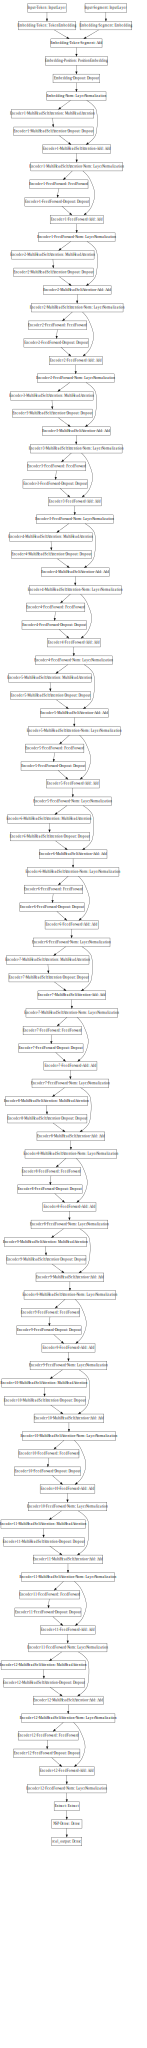

In [29]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


bert_model을 get_bert_finetuning_model 함수로 불러들입니다.
이 다음에 bert_model.fit을 활용하여 버트 모형 파인튜닝을 시작하게 됩니다.
실시간으로 테스트 데이터에 대한 정확도를 알기 위해 validation_data = (test_x, test_y)로 정하였습니다.

**2 에포크 만에 정확도가 88.02%에 도달함을 알 수 있습니다.**  
  

만약에 ETRI에서 만든 한국어로 학습된 BERT 모형을 사용하면 정확도가 90%가 넘기도 합니다.(조만간 ETRI BERT를 활용하여 정확도 높이는 기법도 알려 드리겠습니다.)  
  

사실 아무 전처리 없이 네이버 감성분석의 정확도가 2 에포크 만에 88.02%가 나온 것은 상당히 고무적인 것입니다.  
  

BiLSTM 이나 어텐션 기법을 사용했을 시 보통 테스트셋에 대한 정확도가 86% 정도로 알려져 있습니다.

In [0]:
from keras.utils import to_categorical

train_y_new = to_categorical(train_y, num_classes=5)
test_y_new = to_categorical(test_y, num_classes=5)

In [36]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y_new, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y_new), shuffle=True)



Train on 15000 samples, validate on 1495 samples
Epoch 1/2
15000/15000 [==============================] - 578s 39ms/step - loss: 1.3407 - acc: 0.3979 - val_loss: 1.2386 - val_acc: 0.4689
Epoch 2/2
15000/15000 [==============================] - 573s 38ms/step - loss: 1.1008 - acc: 0.5121 - val_loss: 1.1045 - val_acc: 0.5251


In [38]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model2 = get_bert_finetuning_model(model)
history = bert_model2.fit(train_x, train_y_new, epochs=5, batch_size=16, verbose = 1, validation_data=(test_x, test_y_new), shuffle=True)

Train on 15000 samples, validate on 1495 samples
Epoch 1/5
15000/15000 [==============================] - 584s 39ms/step - loss: 1.0377 - acc: 0.5652 - val_loss: 1.0735 - val_acc: 0.5438
Epoch 2/5
15000/15000 [==============================] - 577s 38ms/step - loss: 0.8942 - acc: 0.6145 - val_loss: 1.0602 - val_acc: 0.5592
Epoch 3/5
15000/15000 [==============================] - 578s 39ms/step - loss: 0.8110 - acc: 0.6511 - val_loss: 1.0835 - val_acc: 0.5485
Epoch 4/5
15000/15000 [==============================] - 578s 39ms/step - loss: 0.7193 - acc: 0.6968 - val_loss: 1.1526 - val_acc: 0.5465
Epoch 5/5
15000/15000 [==============================] - 578s 39ms/step - loss: 0.6233 - acc: 0.7423 - val_loss: 1.2355 - val_acc: 0.5505


# 이진분류 도전

In [0]:
label = list(data['label'])

binary_label = []

for i in range(len(label)):
  if label[i] == 1 or label[i] == 2 or label[i] == 3:
    binary_label = 0
  elif label[i] == 4 or label[i] ==  5:
    binary_label = 1
data['bin_label'] = binary_label
data

,Unnamed: 0,product,brand,user,star,review,label,clear_review,bin_label
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...,4,일단 커서 좋고 거품잘나서 좋고 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머리를...,0
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...,4,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다 거품낼 때 거칠고 뻣뻣한 ...,0
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,2,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,0
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ...",4,우선 저는 건성 입니다 읭 네 저도 희안해요 저의 문제는 두피가 너무 건조해서 하...,0
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...,1,기름기 하나는 확실히 잡아줌 두피는 지성인데 25일 동안 머리 안 감아도 떡 안 짐...,0
...,...,...,...,...,...,...,...,...,...
16491,16491,프리미엄TS샴푸,TS,후회없는청춘,별세개,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...,2,탈모 방지 샴푸라 주변에서 많이 사용해서 사용해봤는데 피부가 약해서 그런지 두피가 ...,0
16492,16492,프리미엄TS샴푸,TS,허모찌,별네개,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다. 머리카락이 가늘고 잘 빠지는 편이라...,3,머리카락이 덜 빠지고 잔머리가 엄청 돋아납니다 머리카락이 가늘고 잘 빠지는 편이라 ...,0
16493,16493,프리미엄TS샴푸,TS,베싸메,별두개,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...,1,엄마의 요청으로 구매 적은 사용으로 풍성한거품 생성 거품이 넘 많이 생성돼서 자극적...,0
16494,16494,프리미엄TS샴푸,TS,빠샤이,별두개,아 어쩐지 아무 효과 없더라.. TS 종류 많은거 몰랐네요.. 다 떨어져서 엄마랑 ...,1,아 어쩐지 아무 효과 없더라 TS 종류 많은거 몰랐네요 다 떨어져서 엄마랑 홈쇼핑에...,0


In [0]:
train_new = data.iloc[0:15000]
test_new = data.iloc[15000:-1]

In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="./devmatcing/bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "clear_review"
LABEL_COLUMN = "bin_label"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN].iloc[i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN].iloc[i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
train

,Unnamed: 0,product,brand,user,star,review,label,clear_review
0,0,녹차실감 샴푸액 지성용,아모스프로페셔널,타이니콩콩,별다섯개,일단 커서 좋고. 거품잘나서 좋고. 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머...,4,일단 커서 좋고 거품잘나서 좋고 특유의 초록빛깔에 알갱이 박힌 느낌이 뭔가 내머리를...
1,1,녹차실감 샴푸액 지성용,아모스프로페셔널,팥죽,별다섯개,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다. 거품낼 때 거칠고 뻣뻣한...,4,거품이 정말 부드럽게 나서 그런지 머리도 부드럽게 감긴다 거품낼 때 거칠고 뻣뻣한 ...
2,2,녹차실감 샴푸액 지성용,아모스프로페셔널,먊먊,별세개,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...,2,샴푸에도 건성 지성이 있구나를 알려준 제품입니다 두피타입에 따라 호불호가 확 갈리겠...
3,3,녹차실감 샴푸액 지성용,아모스프로페셔널,깽우니,별다섯개,"우선 저는 #건성 입니다. (읭?) 네 저도 희안해요. 저의 문제는 ,,, 두피가 ...",4,우선 저는 건성 입니다 읭 네 저도 희안해요 저의 문제는 두피가 너무 건조해서 하...
4,4,녹차실감 샴푸액 지성용,아모스프로페셔널,늘양,별두개,기름기 하나는 확실히 잡아줌. 두피는 지성인데 2.5일 동안 머리 안 감아도 떡 안...,1,기름기 하나는 확실히 잡아줌 두피는 지성인데 25일 동안 머리 안 감아도 떡 안 짐...
...,...,...,...,...,...,...,...,...
14995,14995,애플 프레쉬 샴푸,헤드앤숄더,alicek2,별세개,"외국에서 살 때 거의 이 샴푸만 썼어요 무난하게 썼는데, 특별히 좋다는 건 못 느꼈네요",2,외국에서 살 때 거의 이 샴푸만 썼어요 무난하게 썼는데 특별히 좋다는 건 못 느꼈네요
14996,14996,애플 프레쉬 샴푸,헤드앤숄더,우단,별다섯개,피지가 진짜많이나와서 이샴푸를 검색하고 사봤어요 어느순간부터 샴푸자리에 당당히 서있...,4,피지가 진짜많이나와서 이샴푸를 검색하고 사봤어요 어느순간부터 샴푸자리에 당당히 서있...
14997,14997,애플 프레쉬 샴푸,헤드앤숄더,밍밍쓰,별다섯개,항상 이 샴푸로 머리감고나면 친구들이 다 물어봄... 샴푸 뭐쓰냐고.. 그럼 머리어...,4,항상 이 샴푸로 머리감고나면 친구들이 다 물어봄 샴푸 뭐쓰냐고 그럼 머리어깨무릎발샴...
14998,14998,애플 프레쉬 샴푸,헤드앤숄더,이쁜앙마,별다섯개,지성 두피라 헤드앤숄더 제품을 쓰게 되었어요^^ 다른 제품의 샴푸를 쓰면 오후만 되...,4,지성 두피라 헤드앤숄더 제품을 쓰게 되었어요 다른 제품의 샴푸를 쓰면 오후만 되어도...


In [0]:
train_x, train_y = load_data(train_new)

100%|██████████| 15000/15000 [00:05<00:00, 2734.16it/s]


In [0]:
test_x, test_y = load_data(test_new)

100%|██████████| 1495/1495 [00:00<00:00, 2844.04it/s]


In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model
  

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 15000 samples, validate on 1495 samples
Epoch 1/2
15000/15000 [==============================] - 572s 38ms/step - loss: 0.0543 - acc: 0.9989 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2/2
15000/15000 [==============================] - 552s 37ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 4.7578e-04 - val_acc: 1.0000


In [0]:
bert_model.save_weights(path+"/bert.h5")

버트 모형을 로드해줍니다. 이미 로드하였던 모델에 계수들만 살짝 얹혀 줍니다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/bert.h5")

파인튜닝한 버트 모형에 test 데이터 셋을 넣어 평가해 봅니다.
사실 머신러닝에서는 정확도인 accuracy도 중요하지만, **F1 score**가 상당히 중요합니다.
  

긍정문장으로 판별된 문장이 진짜로 **긍정 문장에 속할 확률**  
  

부정문장으로 판별된 문장이 진짜로 **부정 문장에 속할 확률**  
 **이 두가지를 고려한 종합적인 성능이 F1 score입니다.**

한번 F1-score를 확인해 보겠습니다.


먼저 테스트 데이터를 버트 모형에 넣을 수 있도록 predict_convert_data 함수를 정의해줍니다. <br> 위에 정의한 convert_data 함수와 다른 점은, test 데이터이기 때문에 label은 고려하지 않는다는 점입니다

In [0]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN].iloc[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [0]:
test_set = predict_load_data(test)

100%|██████████| 1495/1495 [00:00<00:00, 2782.62it/s]


In [0]:
test_set

[array([[  101,  9546,   119, ..., 54780,  9041,   102],
        [  101, 83953,  9638, ...,     0,     0,     0],
        [  101,  9638, 41521, ...,     0,     0,     0],
        ...,
        [  101,  9265, 12692, ...,     0,     0,     0],
        [  101,  9553, 23811, ...,     0,     0,     0],
        [  101,  9519,  9546, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

테스트 셋으로 예측하기

In [0]:
#예측
preds = bert_model.predict(test_set)

In [0]:
# 부정이면 0, 긍정이면 1 출력
preds

array([[0.99999994],
       [1.        ],
       [0.99999994],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [0]:
from sklearn.metrics import classification_report

In [0]:
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.12      1.00      0.22       184
           2       0.00      0.00      0.00       358
           3       0.00      0.00      0.00       488
           4       0.00      0.00      0.00       361

    accuracy                           0.12      1495
   macro avg       0.02      0.20      0.04      1495
weighted avg       0.02      0.12      0.03      1495



F1 스코어와 Accuracy가 거의 비슷함을 알 수 있습니다. 훈련이 치우치지 않고 잘 됐음을 알 수 있습니다.